In [16]:
import pandas as pd
import duckdb
import os
import os, json
from uuid import uuid4
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

In [2]:
conn = duckdb.connect('/srv/data/greek/grela.duckdb', read_only=True)

In [3]:
# SQL Query for extracting data
query = """
SELECT
    t.sentence_id,
    t.grela_id,
    t.token_text,
    t.lemma,
    t.pos AS pos_tag,
    t.char_start,
    t.char_end,
    s.text AS sentence_text,
    s.position AS sentence_position,
    w.*
FROM
    tokens t
JOIN
    sentences s
ON
    t.sentence_id = s.sentence_id
JOIN
    works w
ON
    s.grela_id = w.grela_id
WHERE
    t.lemma = 'labyrinthus';
"""

In [4]:
# Execute the query and fetch the result as a Pandas DataFrame
result_df = conn.execute(query).fetchdf()

In [5]:
result_df.head(5)

,sentence_id,grela_id,token_text,lemma,pos_tag,char_start,char_end,sentence_text,sentence_position,grela_source,grela_id_1,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,noscemus_place,noscemus_genre,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random
0,cc_12132_48965,cc_12132,labyrinthorum,labyrinthus,NOUN,41,54,"Est et picturae genus maeander, in morem labyr...",48965,cc,cc_12132,Desiderius Erasmus,Adagia1508\n,1466.0,1536.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1493.0
1,cc_12138_539,cc_12138,labyrinthis,labyrinthus,NOUN,1112,1123,"Scribunt Annales Sinici, in eodem Natali solo ...",539,cc,cc_12138,"Kircher, Athanasius","China illustrata, pars III",1602.0,1680.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1644.0
2,cc_12150_169,cc_12150,labyrinthus,labyrinthus,NOUN,26,37,"Caput 48 Psammetichi opus labyrinthus, domos m...",169,cc,cc_12150,Pomponius Mela,De chorographia,45.0,45.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,45.0
3,cc_12156_1754,cc_12156,labyrinthorum,labyrinthus,NOUN,18,31,"Hoc anfractuum et labyrinthorum occasione, et ...",1754,cc,cc_12156,"Vesalius, Andreas","De humani corporis fabrica, liber primus",1514.0,1564.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1528.0
4,cc_12172_17967,cc_12172,Labyrinthus,labyrinthus,PROPN,62,73,"Ut in AEgypti pyramidibus, maximae enim hae fu...",17967,cc,cc_12172,"Cardanus, Hieronymus",De subtilitate,1501.0,1576.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1517.0


In [7]:
def get_context(sentence_id):
    """
    Retrieve the text of the immediately preceding, target, and immediately following sentences 
    based on the sentence_id.
    
    Args:
        sentence_id (str): The ID of the target sentence.

    Returns:
        str: Concatenated text of the three sentences ('preceding | target | following').
    """
    query = """
    WITH context AS (
        SELECT 
            text, position, sentence_id, grela_id
        FROM 
            sentences
        WHERE
            sentence_id = ?
    ),
    neighbors AS (
        SELECT 
            s.text, 
            s.position
        FROM 
            sentences s
        JOIN 
            context c
        ON 
            s.grela_id = c.grela_id
        WHERE 
            s.position BETWEEN c.position - 1 AND c.position + 1
        ORDER BY 
            s.position
    )
    SELECT 
        STRING_AGG(text, ' | ') AS context_text
    FROM 
        neighbors;
    """

    # Execute the query with the given `sentence_id`
    result = conn.execute(query, [sentence_id]).fetchone()
    return result[0] if result else None

# Example application: Adding context in a new DataFrame column
result_df["context_3sents"] = result_df["sentence_id"].apply(get_context)

In [8]:
result_df.head(5)

,sentence_id,grela_id,token_text,lemma,pos_tag,char_start,char_end,sentence_text,sentence_position,grela_source,grela_id_1,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,noscemus_place,noscemus_genre,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,context_3sents
0,cc_12132_48965,cc_12132,labyrinthorum,labyrinthus,NOUN,41,54,"Est et picturae genus maeander, in morem labyr...",48965,cc,cc_12132,Desiderius Erasmus,Adagia1508\n,1466.0,1536.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1493.0,"Maeander, ortus e lacu in monte Aulocrene plur..."
1,cc_12138_539,cc_12138,labyrinthis,labyrinthus,NOUN,1112,1123,"Scribunt Annales Sinici, in eodem Natali solo ...",539,cc,cc_12138,"Kircher, Athanasius","China illustrata, pars III",1602.0,1680.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1644.0,"Natus itaque Xaca, primum, quod perpetrasse di..."
2,cc_12150_169,cc_12150,labyrinthus,labyrinthus,NOUN,26,37,"Caput 48 Psammetichi opus labyrinthus, domos m...",169,cc,cc_12150,Pomponius Mela,De chorographia,45.0,45.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,45.0,"Moeris, aliquando campus nunc lacus uiginti mi..."
3,cc_12156_1754,cc_12156,labyrinthorum,labyrinthus,NOUN,18,31,"Hoc anfractuum et labyrinthorum occasione, et ...",1754,cc,cc_12156,"Vesalius, Andreas","De humani corporis fabrica, liber primus",1514.0,1564.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1528.0,b 2 Foramen ex auditus organi amplitudinis med...
4,cc_12172_17967,cc_12172,Labyrinthus,labyrinthus,PROPN,62,73,"Ut in AEgypti pyramidibus, maximae enim hae fu...",17967,cc,cc_12172,"Cardanus, Hieronymus",De subtilitate,1501.0,1576.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,1517.0,et haec diu durant per successiones. | Ut in A...


In [9]:
len(result_df)

924

In [10]:
# Corrected SQL Query
query = """
WITH target_tokens AS (
    SELECT 
        t.sentence_id,
        t.grela_id,
        t.token_text AS target_token,
        t.lemma,
        ROW_NUMBER() OVER (PARTITION BY t.sentence_id ORDER BY t.char_start) AS token_position
    FROM tokens t
    WHERE t.lemma = 'labyrinthus'
),
context_tokens AS (
    SELECT
        t.sentence_id,
        t.grela_id,
        t.token_text,
        ROW_NUMBER() OVER (PARTITION BY t.sentence_id ORDER BY t.char_start) AS token_position
    FROM tokens t
),
concordances AS (
    SELECT
        target.sentence_id,
        target.grela_id,
        target.target_token,
        STRING_AGG(c.token_text, ' ') AS concordance
    FROM target_tokens target
    JOIN context_tokens c
    ON target.sentence_id = c.sentence_id
    WHERE c.token_position BETWEEN target.token_position - 10 AND target.token_position + 10
    GROUP BY target.sentence_id, target.grela_id, target.target_token
)
SELECT * FROM concordances;
"""

# Execute the query and fetch results into a Pandas DataFrame
concordance_df = conn.execute(query).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

             sentence_id         grela_id target_token  \
0  noscemus_607725_23015  noscemus_607725  Labyrinthum   
1  noscemus_732034_21345  noscemus_732034   labyrintho   
2    noscemus_928135_286  noscemus_928135  labyrinthos   
3   noscemus_732630_8837  noscemus_732630   Labyrintho   
4      emlap_100045_1368     emlap_100045  labyrinthum   

                                         concordance  
0  Fotamen ad secundam cauernam , siue Labyrinthu...  
1  Um operi huic summa cura insistenti complures ...  
2  In hac tamen parte , quae motus locales partiu...  
3  Scio tamen eum in Logicis aliquid scripsisse ,...  
4  Sed postquam hominum sapiendi per seipsos uanu...  


In [11]:
concordance_df.head(5)

,sentence_id,grela_id,target_token,concordance
0,noscemus_607725_23015,noscemus_607725,Labyrinthum,"Fotamen ad secundam cauernam , siue Labyrinthu..."
1,noscemus_732034_21345,noscemus_732034,labyrintho,Um operi huic summa cura insistenti complures ...
2,noscemus_928135_286,noscemus_928135,labyrinthos,"In hac tamen parte , quae motus locales partiu..."
3,noscemus_732630_8837,noscemus_732630,Labyrintho,"Scio tamen eum in Logicis aliquid scripsisse ,..."
4,emlap_100045_1368,emlap_100045,labyrinthum,Sed postquam hominum sapiendi per seipsos uanu...


In [12]:
merged_df = pd.merge(result_df, concordance_df[["sentence_id", "concordance", "target_token"]], on="sentence_id", how="right")

<Axes: >

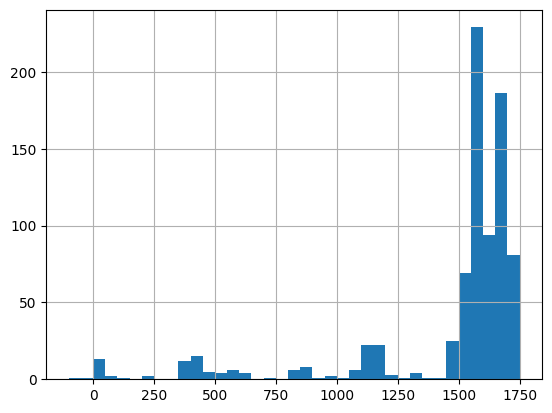

In [17]:
fig, ax = plt.subplots()
merged_df["date_random"].hist(bins=range(-100, 1800, 50), ax=ax)

In [19]:
fig.savefig("../figures/labyrinthus_temp.png", dpi=300, bbox_inches="tight")

In [15]:
merged_df.to_csv("../data/labyrinthus_grela.csv")